In [1]:
from fastbook import *
from fastai.tabular.all import *
from fastai.tabular import *

In [2]:
path = URLs.path('titanic')

In [3]:
df = pd.read_csv(path/'train.csv', low_memory=False)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
pd.pivot_table(df, index='Survived',
               values = ['Age', 'SibSp','Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [5]:
# df['Title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [6]:
# df

In [7]:
# xs_final = load_pickle(path/'xs_imp.pkl')
# valid_xs_final = load_pickle(path/'valid_xs_imp.pkl')

In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
# xs_final.columns

In [10]:
dep_var = 'Survived'
df[dep_var].shape

(891,)

In [11]:
# df.drop(['Name', 'Ticket'], axis=1)
# df.drop(['Name'], axis=1)

In [12]:
cont_names, cat_names = cont_cat_split(df, 3, dep_var=dep_var)

In [13]:
cont_names, cat_names

(['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])

In [14]:
# cat_names.remove('Name')
# cat_names

In [15]:
procs = [Categorify, FillMissing, Normalize]

In [16]:
splits = RandomSplitter()(range_of(df))

In [17]:
y_block = CategoryBlock()

In [18]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   splits=splits, y_names=dep_var, y_block=y_block)

In [19]:
to

     PassengerId  Survived  Pclass  Name  Sex       Age     SibSp     Parch  \
788     1.324792         1       3   209    2 -2.182090  0.461591  2.034995   
525     0.310172         0       3   245    2  0.861921 -0.462887 -0.464491   
821     1.452102         1       3   494    2 -0.178437 -0.462887 -0.464491   
253    -0.739169         0       3   488    2  0.052753  0.461591 -0.464491   
374    -0.272367         0       3   626    1 -2.027963  2.310547  0.785252   
..           ...       ...     ...   ...  ...       ...       ...       ...   
770     1.255351         0       3   481    2 -0.409628 -0.462887 -0.464491   
414    -0.118052         1       3   793    2  1.131643 -0.462887 -0.464491   
540     0.368040         1       1   189    1  0.515135 -0.462887  2.034995   
298    -0.565565         1       1   715    2 -0.101374 -0.462887 -0.464491   
489     0.171288         1       3   183    2 -1.565582  0.461591  0.785252   

     Ticket      Fare  Cabin  Embarked  Age_na  
78

In [20]:
dls = to.dataloaders(bs=8)

In [21]:
dls.show_batch()

,Pclass,Name,Sex,Ticket,Cabin,Embarked,Age_na,PassengerId,Age,SibSp,Parch,Fare,Survived
0,3,"McGowan, Miss. Anna ""Annie""",female,330923,#na#,Q,False,22.999998,15.000000,1.689237e-09,-9.897945e-09,8.029199,1
1,3,"Kelly, Mr. James",male,363592,#na#,S,False,696.999993,44.000000,1.689237e-09,-9.897945e-09,8.050001,0
2,1,"Van der hoef, Mr. Wyckoff",male,111240,B19,S,False,171.000013,60.999999,1.689237e-09,-9.897945e-09,33.500000,0
3,3,"Sage, Mr. Douglas Bullen",male,CA. 2343,#na#,S,True,847.000013,28.000000,8.000000e+00,2.000000e+00,69.550003,0
4,3,"Danoff, Mr. Yoto",male,349219,#na#,S,False,321.999997,27.000000,1.689237e-09,-9.897945e-09,7.895800,0
5,1,"Daly, Mr. Peter Denis",male,113055,E17,S,False,858.000014,51.000001,1.689237e-09,-9.897945e-09,26.549999,1
6,2,"Garside, Miss. Ethel",female,243880,#na#,S,False,576.999992,34.000000,1.689237e-09,-9.897945e-09,13.000001,1
7,3,"Gustafsson, Mr. Alfred Ossian",male,7534,#na#,S,False,877.000001,20.000000,1.689237e-09,-9.897945e-09,9.845801,0


In [22]:
learn = tabular_learner(dls, layers=[400, 800], metrics=accuracy)

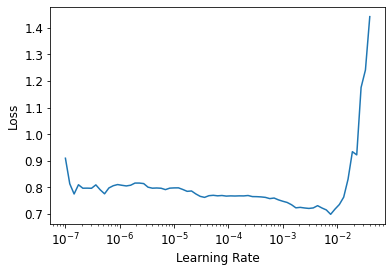

In [23]:
lr_min, lr_steep = learn.lr_find()

In [24]:
lr_min

0.0007585775572806596

In [25]:
learn.fit_one_cycle(5, lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.717904,1.009692,0.724719,00:00
1,1.126472,0.574592,0.780899,00:00
2,0.536005,0.398579,0.853933,00:00
3,0.234112,0.384981,0.831461,00:00
4,0.128277,0.401601,0.831461,00:00


In [26]:
# preds, targets = learn.get_preds()

In [27]:
# learn.summary()

In [28]:
learn.show_results()

,Pclass,Name,Sex,Ticket,Cabin,Embarked,Age_na,PassengerId,Age,SibSp,Parch,Fare,Survived,Survived_pred
0,3.0,751.0,2.0,486.0,0.0,3.0,2.0,1.513828,-0.101374,-0.462887,-0.464491,-0.471155,0.0,0.0
1,1.0,541.0,1.0,93.0,79.0,2.0,1.0,-0.125768,0.283944,0.461591,-0.464491,1.126327,1.0,1.0
2,3.0,427.0,1.0,394.0,0.0,1.0,1.0,0.950579,-1.950899,-0.462887,0.785252,-0.366539,1.0,1.0
3,1.0,846.0,1.0,5.0,105.0,1.0,1.0,-0.303230,2.364661,0.461591,-0.464491,0.838800,1.0,1.0
4,3.0,318.0,2.0,499.0,0.0,3.0,2.0,0.175146,-0.101374,0.461591,-0.464491,-0.238858,0.0,0.0
5,3.0,117.0,2.0,439.0,0.0,2.0,1.0,-1.163535,-0.794946,-0.462887,-0.464491,-0.496496,0.0,0.0
6,1.0,189.0,1.0,681.0,21.0,3.0,1.0,0.368040,0.515135,-0.462887,2.034995,0.755953,1.0,1.0
7,3.0,102.0,2.0,436.0,0.0,2.0,1.0,-0.989931,0.823389,0.461591,0.785252,-0.325929,0.0,0.0


In [29]:
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_test;

In [30]:
# df_test['Title'] = df_test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [31]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [32]:
# df_test.dropna(subset=['Fare'], inplace=True)
df_test.loc[df_test.Fare.isnull(), 'Fare'] = np.mean(df.Fare)

In [33]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [34]:
to_test = to.new(df_test)

In [35]:
to_test.process()

In [36]:
to_test.items.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1.722153,3,434,2,0.399539,-0.462887,-0.464491,0,-0.475459,0,2,1
1,1.726011,3,0,1,1.362834,0.461591,-0.464491,0,-0.491623,0,3,1
2,1.729869,2,0,2,2.518788,-0.462887,-0.464491,0,-0.439234,0,2,1
3,1.733727,3,0,2,-0.178437,-0.462887,-0.464491,0,-0.459215,0,3,1
4,1.737585,3,0,1,-0.563755,0.461591,0.785252,252,-0.388551,0,3,1


In [37]:
test_dl = dls.valid.new(to_test)

In [38]:
test_dl.show_batch()

,Pclass,Name,Sex,Ticket,Cabin,Embarked,Age_na,PassengerId,Age,SibSp,Parch,Fare
0,3,"Kelly, Mr. James",male,#na#,#na#,Q,False,892.000011,34.500000,1.689237e-09,-9.897945e-09,7.829201
1,3,#na#,female,#na#,#na#,S,False,893.000006,47.000000,1.000000e+00,-9.897945e-09,7.000000
2,2,#na#,male,#na#,#na#,Q,False,894.000000,61.999999,1.689237e-09,-9.897945e-09,9.687500
3,3,#na#,male,#na#,#na#,S,False,894.999995,27.000000,1.689237e-09,-9.897945e-09,8.662500
4,3,#na#,female,3101298,#na#,S,False,895.999989,22.000000,1.000000e+00,1.000000e+00,12.287500
5,3,#na#,male,#na#,#na#,S,False,897.000014,14.000001,1.689237e-09,-9.897945e-09,9.225000
6,3,"Connolly, Miss. Kate",female,#na#,#na#,Q,False,898.000009,30.000000,1.689237e-09,-9.897945e-09,7.629200
7,2,#na#,male,248738,#na#,S,False,899.000003,26.000000,1.000000e+00,1.000000e+00,29.000000


In [39]:
dl = learn.dls.test_dl(df_test)

In [40]:
y_test, _  = learn.get_preds(dl=dl)

In [41]:
submit = pd.DataFrame({
    "PassengerId": df_test.PassengerId,
    "Survived": np.argmax(y_test, axis=1)
})
submit

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [42]:
submit.to_csv(path/'submission_nn.csv', index=False)